In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import product
from sklearn.preprocessing import label_binarize
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the data
x_train = pd.read_csv("/content/drive/MyDrive/models/data/X_train.csv")
x_test = pd.read_csv("/content/drive/MyDrive/models/data/X_test.csv")
y_train = pd.read_csv("/content/drive/MyDrive/models/data/y_train.csv")
y_test = pd.read_csv("/content/drive/MyDrive/models/data/y_test.csv")

Using device: cuda
x_train shape: (454904, 30)
x_test shape: (113726, 30)
y_train shape: (454904, 1)
y_test shape: (113726, 1)


In [ ]:
# Convert to numpy arrays
x_train_np = x_train.to_numpy()
x_test_np = x_test.to_numpy()
y_train_np = y_train.to_numpy().squeeze()  # Convert to 1D
y_test_np = y_test.to_numpy().squeeze()    # Convert to 1D

# Normalize features
scaler = StandardScaler()
x_train_np = scaler.fit_transform(x_train_np)
x_test_np = scaler.transform(x_test_np)

# Reshape for LSTM: (num_samples, seq_length, num_features)
x_train_np = x_train_np.reshape((x_train_np.shape[0], 1, x_train_np.shape[1]))
x_test_np = x_test_np.reshape((x_test_np.shape[0], 1, x_test_np.shape[1]))

# Convert numpy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train_np, dtype=torch.float32).cuda()
x_test_tensor = torch.tensor(x_test_np, dtype=torch.float32).cuda()
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).cuda()
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).cuda()

# Create DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Parameter(torch.randn(hidden_dim))

    def forward(self, hidden_states):
        scores = torch.tanh(self.W(hidden_states))
        scores = torch.matmul(scores, self.v.unsqueeze(0).unsqueeze(-1)).squeeze(-1)
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), hidden_states).squeeze(1)
        return context

class LSTMWithAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.attention = Attention(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out = self.attention(lstm_out)
        out = self.fc(attn_out)
        return out

In [ ]:
# Model parameters
input_dim = x_train_tensor.shape[2]  # Number of features
hidden_dim = 128
output_dim = 1  # Binary classification
num_layers = 1

# Initialize the model
model = LSTMWithAttention(input_dim, hidden_dim, output_dim, num_layers).cuda()

def train_model(model, train_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Compute predictions and accuracy
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct / total
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    print("Training complete.")

# Training the model
train_model(model, train_loader)

Epoch 1/10, Loss: 0.0127, Accuracy: 0.9966
Epoch 2/10, Loss: 0.0024, Accuracy: 0.9995
Epoch 3/10, Loss: 0.0017, Accuracy: 0.9996
Epoch 4/10, Loss: 0.0013, Accuracy: 0.9997
Epoch 5/10, Loss: 0.0011, Accuracy: 0.9997
Epoch 6/10, Loss: 0.0010, Accuracy: 0.9998
Epoch 7/10, Loss: 0.0009, Accuracy: 0.9998
Epoch 8/10, Loss: 0.0007, Accuracy: 0.9998
Epoch 9/10, Loss: 0.0006, Accuracy: 0.9999
Epoch 10/10, Loss: 0.0005, Accuracy: 0.9999
Training complete.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Compute metrics
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds)

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    # Print confusion matrix and classification report
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()

Confusion Matrix:
[[56851    12]
 [   23 56840]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56863
         1.0       1.00      1.00      1.00     56863

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



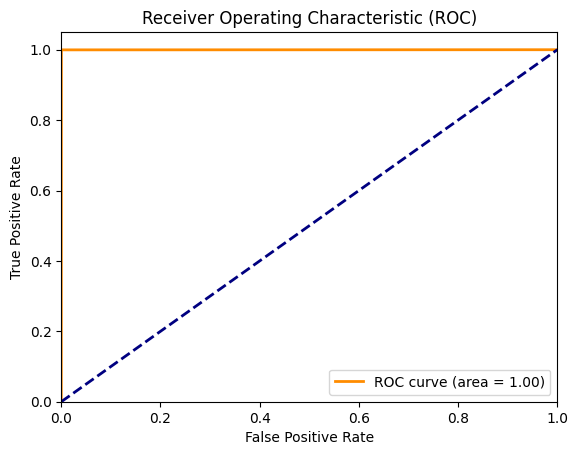

In [ ]:
# Evaluating the model
evaluate_model(model, test_loader)

In [ ]:
# Save the model
model_path = "lstm_attention_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to lstm_attention_model.pth
